# FVmax analysis

Works on jupyterlab3

Measure the evolution of the heigth of the FV Gaussians

In [1]:
%pylab ipympl
from astropy import units
from nugridpy import utils as ut
from scipy import interpolate
from scipy import stats
from scipy.optimize import curve_fit 
from scipy.optimize import minimize
import sys
ppmpy_dir = '/home/user/user/niagara_scratch_sblouin/PyPPM'
sys.path.insert(0,ppmpy_dir)
from ppmpy import ppm  
logging.getLogger("matplotlib").setLevel(logging.ERROR)
from scipy import stats
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import summary_table
code_mass = 5.025e-07  # code unit of mass in solar masses

Populating the interactive namespace from numpy and matplotlib


In [2]:
def where_near(t,tt_arr,num_arr=None):
    '''Finds n in num that corresponds closest to t in tt_sec
    
    Parameters:
    -----------
    
    t :: scalar, float
      time in seconds we seek the dump number for
    
    tt_arr : array, float
      time in seconds for each dump
      
    num_arr :: array, int or float
      dump number array
      The default is that num_arr is the grid number, and then 
      the input, for example, (R, Rgrid) will return the neares grid 
      number of R in the Rgrid array.
    
    Returns:
    --------
    
    num_t :: int/float depending on type of NDump
      interpolated value in num_arr corresponding to t in tt_arr
    
    '''
    if num_arr is None:
        num_arr = arange(0,len(tt_arr),1)
    f_int = interpolate.interp1d(tt_arr,num_arr,kind='linear',fill_value="extrapolate")
    num_t = float(f_int(t))
    if type(num_arr[0]) in [int64,int]: 
        num_t = int(round(num_t,0))
    return num_t


In [3]:
def initialize(data,dir,cases,nominal_heat = 1,eos='g'):
    '''Initialize Rprof data for one run
    
    nominal_heat   nominal heat, from PPMstar code, so that X_Lfactors is factor wrt nominal heat
    '''
    for case in cases:
        data[case] = {}
        data[case]['path'] = dir+case+'/prfs' 
        data[case]['rp'] = ppm.RprofSet(data[case]['path'] )
        data[case]['rph'] = data[case]['rp'].get_history()
        data[case]['NDump'] = data[case]['rph'].get('NDump')
        data[case]['time(mins)'] = data[case]['rph'].get('time(mins)')
        data[case]['time(secs)'] = data[case]['rph'].get('time(secs)')
        data[case]['rp_one'] = data[case]['rp'].get_dump(data[case]['NDump'][0])
        data[case]['X_Lfactors'] = data[case]['rp_one'].get('totallum')/nominal_heat
        data[case]['grids'] = data[case]['rp_one'].get('Nx') 
        data[case]['eos'] = eos        
    return data

In [4]:
# Data dictionary to hold the data for the different cases analysed in this nb
data = {}  
cases = []

In [5]:
eos = 'r'
dir = '/home/user/user/niagara_scratch_sblouin/'  
cases1 = ['X30']
data = initialize(data,dir, cases1,eos=eos)

701 rprof files found in '/home/user/user/niagara_scratch_sblouin/X30/prfs/.
Dump numbers range from 0 to 700.


In [6]:
all_cases = list(data.keys())
cases = all_cases 
cases

['X30']

In [7]:
def gauss(x, *p):
    A, mu, sigma = p
    return A*np.exp(-(x-mu)**2/(2.*sigma**2))

Text(0, 0.5, 'FV')

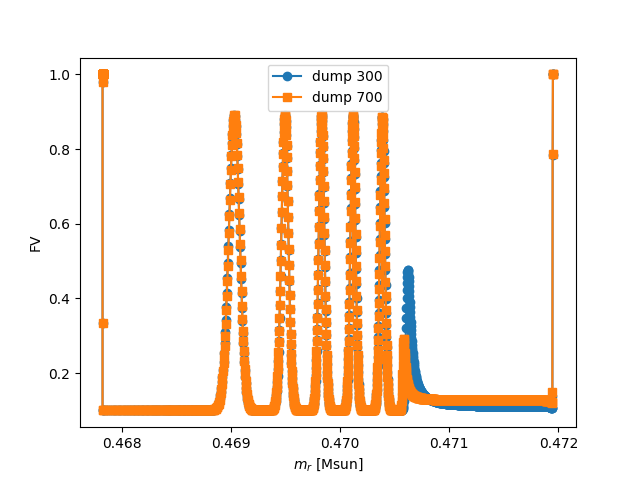

In [8]:
case = all_cases[0]
rpo = data[case]['rp_one']
close(1679);figure(1679)
dump = 300
m = data[case]['rp'].compute_m(dump)*code_mass
FV = data[case]['rp'].get('FV',fname=dump)
R = data[case]['rp'].get('R',fname=dump)
plot(m,FV,'-o',label='dump '+str(dump))
dump = 700
m = data[case]['rp'].compute_m(dump)*code_mass
FV = data[case]['rp'].get('FV',fname=dump)
R = data[case]['rp'].get('R',fname=dump)
plot(m,FV,'-s', label='dump '+str(dump))
#xlim(0.4685,0.4714)

legend()
xlabel('$m_r$ [Msun]')
ylabel('FV')

In [9]:
# dumpstart = int(300/sparse); dumpend = int(700/sparse)

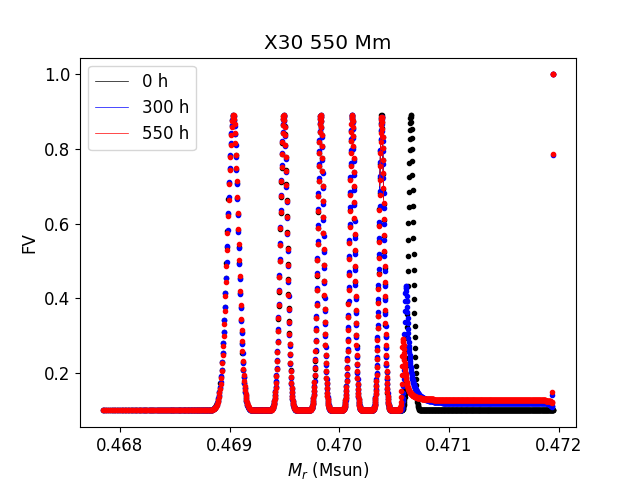

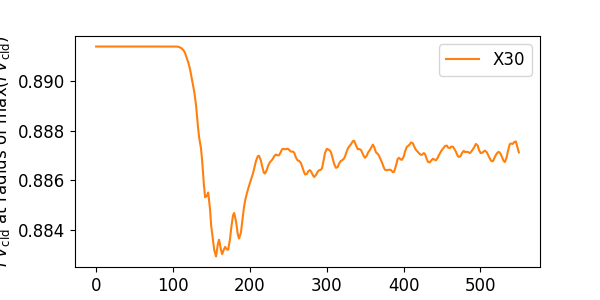

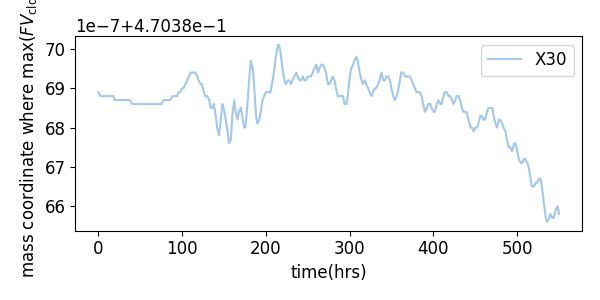

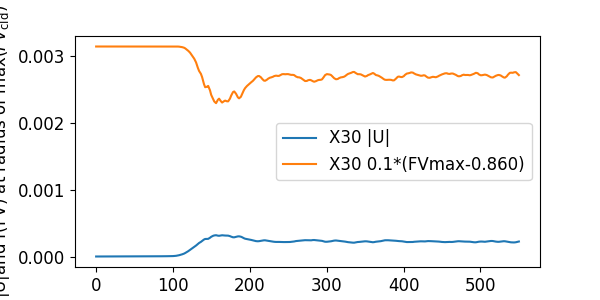

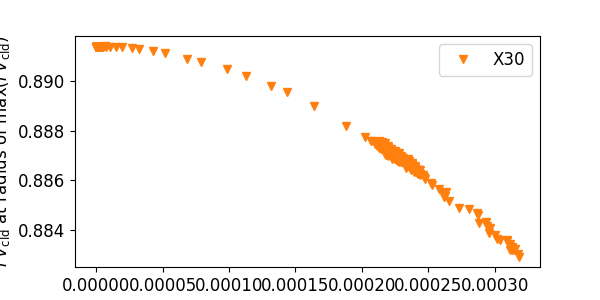

In [40]:
%%capture --no-display
# 
key = "FVcld_max" # for name

close(56);figure(56)

case = cases[0]
logy = False
sparse = 2.
num_type = 't' 

# BUMP SETUP
#mlims = (0.302,0.3045) #2nd peak

# TIP SETUP
# mlims = (.47035,.47055) # 4th peak
#mlims = (.470,.4702) # 3rd peak
#mlims = (0.4695,0.4698) # 2nd peak
#mlims = (.4685,.4693) # 1st peak

# X30
mlims = (.4703+7e-5,.4703+10.5e-5) #5th peak
# mlims = (.4701,.47014) #4th peak
# mlims = (.4698+1e-5,.4698+5e-5) #3rd peak
# mlims = (.46935, .46965) #2nd peak

code_mass = 5.025e-07  # code unit of mass in solar masses
s = 0
t_s_per_hr = 3600
ifig=1394; close(ifig); figure(ifig,figsize=(6,3))
ifig=1395; close(ifig); figure(ifig,figsize=(6,3))
ifig=1396; close(ifig); figure(ifig,figsize=(6,3))
ifig=1397; close(ifig); figure(ifig,figsize=(6,3))
out_dat = {}
for i,case in enumerate(cases):
    m_hr = arange(*mlims,0.00000001)
    out_dat[case] = {}
    print("Case: {:s}".format(case))
    FVmax = []
    mass_FVmax = []
    radius_FVmax = []
    Rhos_FVmax = []
    Umags_FVmax = []
    times = []
    coeffs = []
    perrs = []
    last_dumps = data[case]['NDump'][-1]
    last_hour = floor(data[case]['rp'].get('t',fname=last_dumps)/3600)
    hour_vec = arange(0,last_hour,sparse)
    for hour in hour_vec:
        dump = hour * t_s_per_hr
        m = data[case]['rp'].compute_m(dump,num_type=num_type)*code_mass
        FV = data[case]['rp'].get('FV',fname=dump,num_type=num_type)
        R = data[case]['rp'].get('R',fname=dump,num_type=num_type)
        Rho = data[case]['rp'].get('Rho0',fname=dump,num_type=num_type)+\
            data[case]['rp'].get('Rho1',fname=dump,num_type=num_type)
        Umag = data[case]['rp'].get('|U|',fname=dump,num_type=num_type)
        # S Blouin
        # Remove dm=0 portion
        dm = diff(m, append=m[-1])
        FV = FV[dm!=0]
        R = R[dm!=0]
        Rho = Rho[dm!=0]
        Umag = Umag[dm!=0]
        m = m[dm!=0]
        #
        f_R_from_m = interpolate.interp1d(m,R,kind='linear',fill_value="extrapolate")
        rlims = f_R_from_m(mlims)
        r_hr = arange(*rlims,0.1)
        #
        # spline fit and find max
        f_Pchip = interpolate.PchipInterpolator(m[::-1],FV[::-1], axis=0, extrapolate=None) 
        tck = interpolate.splrep(m[::-1],FV[::-1], s=s)
        FV_hr = interpolate.splev(m_hr, tck, der=0)
        if hour==0 or hour==300 or hour==550:
            figure(56)
            if hour==0: color='k';label='0 h'
            if hour==300: color='b';label='300 h'
            if hour==550: color='r';label='550 h'
            plot(m_hr,FV_hr,'-',lw=.5,color=color,label=label)
            plot(m,FV,'.',color=color)
        FVmax.append(max(FV_hr))
        mass_FVmax.append(m_hr[where(max(FV_hr)==FV_hr)[0][0]])
#         FVmax.append(min(FV_hr))
#         mass_FVmax.append(m_hr[where(min(FV_hr)==FV_hr)[0][0]])
        f_Pchip = interpolate.PchipInterpolator(R[::-1],FV[::-1], axis=0, extrapolate=None) 
        tck = interpolate.splrep(R[::-1],FV[::-1], s=s)
        FV_hr = interpolate.splev(r_hr, tck, der=0)
        Rh_FVmax = r_hr[where(max(FV_hr)==FV_hr)[0][0]]
        radius_FVmax.append(Rh_FVmax)
        rho_FVmax = where_near(Rh_FVmax,R,Rho)
        Rhos_FVmax.append(rho_FVmax)
        Umag_FVmax =  where_near(Rh_FVmax,R,Umag)
        Umags_FVmax.append(Umag_FVmax)
        times.append(data[case]['rp'].get('t',fname=dump,num_type=num_type)/60.) # times in min
        #
        # Gauss fit
        ind    = (R > rlims[0])*(R < rlims[1]) 
        Rmax = R[ind][(FV[ind] == max(FV[ind]))][0]
        p0 = [FVmax[-1], Rmax, 8]
        coeff, var_matrix = curve_fit(gauss, R[ind],FV[ind]-0.1, p0=p0)
        if hour==0 or hour==300 or hour==550:
            figure(56)
            if hour==0: color='k'
            if hour==300: color='b'
            if hour==550: color='r'
            plot(m_hr,gauss(f_R_from_m(m_hr),*coeff)+.1,'--',lw=.5,color=color)
        perr = np.sqrt(np.diag(var_matrix))
        coeffs.append(coeff)
        perrs.append(perr)
    FVmax = array(FVmax); times = array(times); coeffs = array(coeffs); perrs = array(perrs)
    mass_FVmax = array(mass_FVmax ); Umags_FVmax = array(Umags_FVmax)
    out_dat[case]['FVmax']=FVmax; out_dat[case]['times']=times; out_dat[case]['mass_FVmax']=mass_FVmax
    out_dat[case]['radius_FVmax']=radius_FVmax; out_dat[case]['coeffs']=coeffs; out_dat[case]['perrs']=perrs
    ifig=1394;  figure(ifig)
    plot(times/60.,FVmax,ut.linestylecb(i)[0],color=ut.colourblind(i+1),\
             label=case)
    ifig=1396;  figure(ifig)
    plot(times/60.,Umags_FVmax,label=case[0:4]+" |U|")
    plot(times/60.,0.1*(FVmax-0.860),label=case[0:4]+' 0.1*(FVmax-0.860)')
#     plot(times/60.,Umags_FVmax,ut.linestylecb(i)[0],color=ut.colourblind(i+1),\
#              label="|U|")
#     plot(times/60.,0.1*(FVmax-0.860),ut.linestylecb(i+1)[0],color=ut.colourblind(i+2),\
#              label='0.1*(FVmax-0.860)')
    ifig=1397;  figure(ifig)
    plot(Umags_FVmax,FVmax,ut.linestylecb(i)[1],color=ut.colourblind(i+1),\
             label=case)
    ifig=1395;  figure(ifig)
#     plot(times/60.,mass_FVmax,ut.linestylecb(i)[0],color=ut.colourblind(i),\
#              label=case)
    plot(times/60.,mass_FVmax,ut.linestylecb(i)[0],color=ut.colourblind(i),\
             label=case)

figure(56)
legend()
ylabel('FV')
xlabel(r'$M_r$ (Msun)')
title('X30 550 Mm')
    
ifig=1394;  figure(ifig)
ylab="$ FV_\mathrm{cld}$ at radius of max($FV_\mathrm{cld}$)"   
ylabel(ylab);xlabel('time(hrs)')
legend(loc=0)

ifig=1396;  figure(ifig)
ylab="|U|and f(FV) at radius of max($FV_\mathrm{cld}$)"   
ylabel(ylab);xlabel('time(hrs)')
legend(loc=0);title('')

ifig=1397;  figure(ifig)
ylab="$ FV_\mathrm{cld}$ at radius of max($FV_\mathrm{cld}$)"   
xlab="|U| at radius of max($FV_\mathrm{cld}$)"   
ylabel(ylab);xlabel(xlab)
legend(loc=0)


ifig=1395;  figure(ifig)
ylab="mass coordinate where max($FV_\mathrm{cld}$) "   
ylabel(ylab);xlabel('time(hrs)')
tight_layout()
legend(loc=0)


Kendall KendalltauResult(correlation=0.11466666666666668, pvalue=0.05688151526517496)
Pearson (0.22341916885733046, 0.011911600439176075)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.050
Model:                            OLS   Adj. R-squared:                  0.042
Method:                 Least Squares   F-statistic:                     6.515
Date:                Tue, 27 Sep 2022   Prob (F-statistic):             0.0119
Time:                        23:49:37   Log-Likelihood:                 842.93
No. Observations:                 126   AIC:                            -1682.
Df Residuals:                     124   BIC:                            -1676.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      

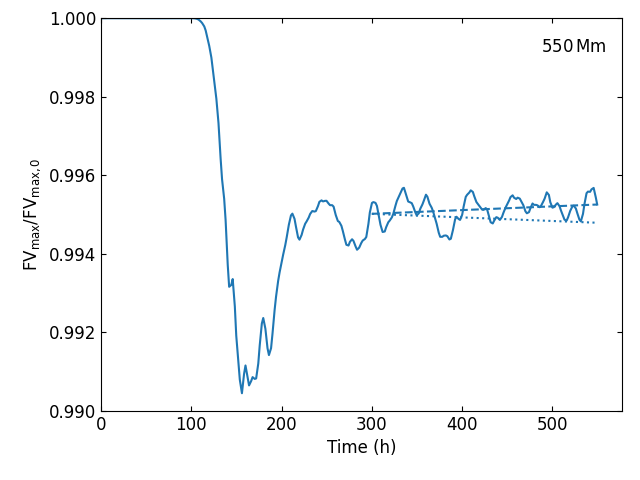

In [42]:
close(57);figure(57)
matplotlib.rcParams.update({'font.size': 12})
#plot(out_dat[case]['times']/60.,out_dat[case]['FVmax']/out_dat[case]['FVmax'][0],'-k', label='FV spline fit', color='tab:blue')
tt = out_dat[case]['times']
x = tt/60
y = (out_dat[case]['coeffs'].T[0]+0.1)/out_dat[case]['FVmax'][0]
plot(x,y,label='Gaussian at 550 Mm', color='tab:blue',ls='-')
#plot(tt/60,-3e-8*tt+0.9954,ls='--')
ylabel(r'FV$_{\rm max}$/FV$_{\rm{max},0}$')
xlabel('Time (h)')
tight_layout()
ax = plt.gca()
ax.tick_params(axis='both',direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ylim(.99,1)
xlim(0,None)
#
tmin = 300
xa,ya = x[x>tmin], y[x>tmin]
print('Kendall',stats.kendalltau(xa,ya))
print('Pearson',stats.pearsonr(xa,ya))
xa = sm.add_constant(xa)
model = sm.OLS(ya,xa)
results = model.fit()
print(results.summary())
b,m = results.params
db,dm = results.bse
#
xx = linspace(300,550)
nsig = 1
nominal = b+m*xx
upper = b+(m-5*dm)*xx
upper = upper + (nominal[0]-upper[0])
plot(xx,nominal,'--')
plot(xx,upper,':',color='tab:blue')
#
text(0.97,0.95,r'550$\,$Mm', transform=ax.transAxes,ha='right',va='top')
savefig('FVmax550.pdf', bbox_inches='tight')
#
print(m/3600,dm/3600)
print((m-dm*5)/3600)
print(log10(-(m-dm*5)/3600*8.3e8**2))

Conclusion: no significant slope. The p-value for a hypothesis test whose null hypothesis is an absence of association (Kendall tau = 0) is 0.057. Also, the linear fit is consistent with 0 slope wo within 2.5 sigma.

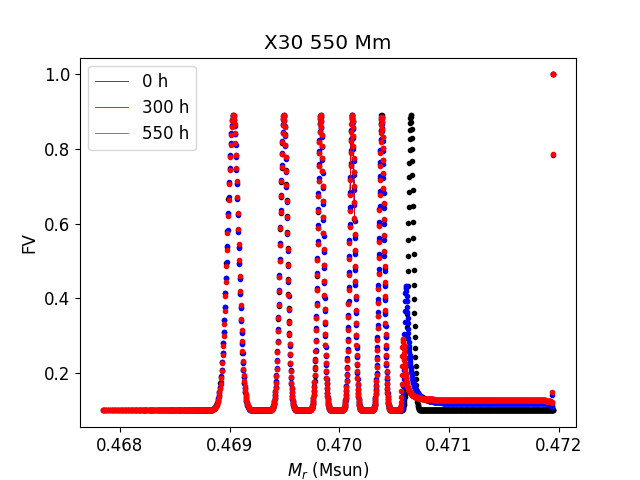

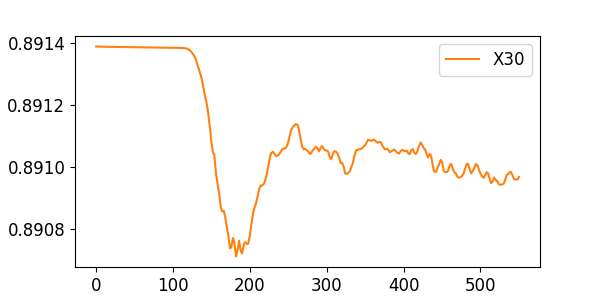

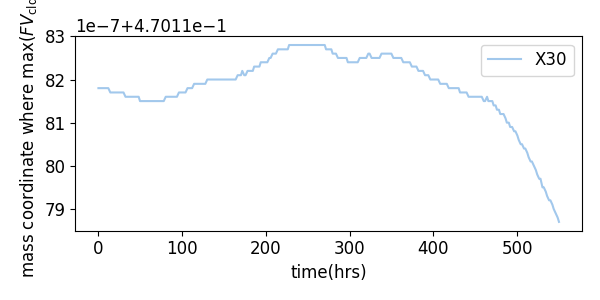

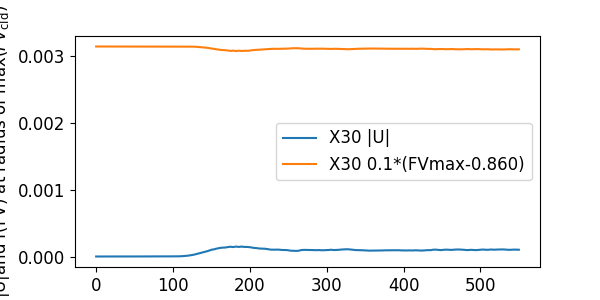

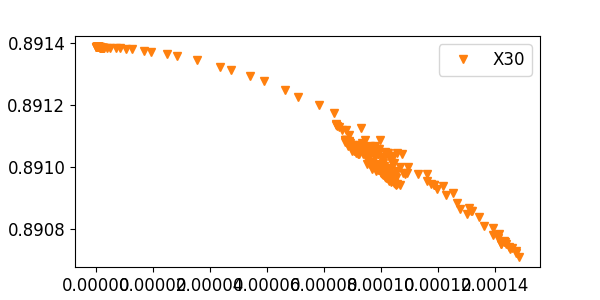

In [36]:
%%capture --no-display
# 
key = "FVcld_max" # for name

close(56);figure(56)

case = cases[0]
logy = False
sparse = 2.
num_type = 't' 

# BUMP SETUP
#mlims = (0.302,0.3045) #2nd peak

# TIP SETUP
#mlims = (.47035,.47055) # 4th peak
#mlims = (.470,.4702) # 3rd peak
#mlims = (0.4695,0.4698) # 2nd peak
#mlims = (.4685,.4693) # 1st peak

# X30
# mlims = (.4703+7e-5,.4703+10.5e-5) #5th peak
mlims = (.4701,.47014) #4th peak
# mlims = (.4698+1e-5,.4698+5e-5) #3rd peak
# mlims = (.46935, .46965) #2nd peak

code_mass = 5.025e-07  # code unit of mass in solar masses
s = 0
t_s_per_hr = 3600
ifig=1394; close(ifig); figure(ifig,figsize=(6,3))
ifig=1395; close(ifig); figure(ifig,figsize=(6,3))
ifig=1396; close(ifig); figure(ifig,figsize=(6,3))
ifig=1397; close(ifig); figure(ifig,figsize=(6,3))
out_dat = {}
for i,case in enumerate(cases):
    m_hr = arange(*mlims,0.00000001)
    out_dat[case] = {}
    print("Case: {:s}".format(case))
    FVmax = []
    mass_FVmax = []
    radius_FVmax = []
    Rhos_FVmax = []
    Umags_FVmax = []
    times = []
    coeffs = []
    perrs = []
    last_dumps = data[case]['NDump'][-1]
    last_hour = floor(data[case]['rp'].get('t',fname=last_dumps)/3600)
    hour_vec = arange(0,last_hour,sparse)
    for hour in hour_vec:
        dump = hour * t_s_per_hr
        m = data[case]['rp'].compute_m(dump,num_type=num_type)*code_mass
        FV = data[case]['rp'].get('FV',fname=dump,num_type=num_type)
        R = data[case]['rp'].get('R',fname=dump,num_type=num_type)
        Rho = data[case]['rp'].get('Rho0',fname=dump,num_type=num_type)+\
            data[case]['rp'].get('Rho1',fname=dump,num_type=num_type)
        Umag = data[case]['rp'].get('|U|',fname=dump,num_type=num_type)
        # S Blouin
        # Remove dm=0 portion
        dm = diff(m, append=m[-1])
        FV = FV[dm!=0]
        R = R[dm!=0]
        Rho = Rho[dm!=0]
        Umag = Umag[dm!=0]
        m = m[dm!=0]
        #
        f_R_from_m = interpolate.interp1d(m,R,kind='linear',fill_value="extrapolate")
        rlims = f_R_from_m(mlims)
        r_hr = arange(*rlims,0.1)
        #
        # spline fit and find max
        f_Pchip = interpolate.PchipInterpolator(m[::-1],FV[::-1], axis=0, extrapolate=None) 
        tck = interpolate.splrep(m[::-1],FV[::-1], s=s)
        FV_hr = interpolate.splev(m_hr, tck, der=0)
        if hour==0 or hour==300 or hour==550:
            figure(56)
            if hour==0: color='k';label='0 h'
            if hour==300: color='b';label='300 h'
            if hour==550: color='r';label='550 h'
            plot(m_hr,FV_hr,'-',lw=.5,color=color,label=label)
            plot(m,FV,'.',color=color)
        FVmax.append(max(FV_hr))
        mass_FVmax.append(m_hr[where(max(FV_hr)==FV_hr)[0][0]])
#         FVmax.append(min(FV_hr))
#         mass_FVmax.append(m_hr[where(min(FV_hr)==FV_hr)[0][0]])
        f_Pchip = interpolate.PchipInterpolator(R[::-1],FV[::-1], axis=0, extrapolate=None) 
        tck = interpolate.splrep(R[::-1],FV[::-1], s=s)
        FV_hr = interpolate.splev(r_hr, tck, der=0)
        Rh_FVmax = r_hr[where(max(FV_hr)==FV_hr)[0][0]]
        radius_FVmax.append(Rh_FVmax)
        rho_FVmax = where_near(Rh_FVmax,R,Rho)
        Rhos_FVmax.append(rho_FVmax)
        Umag_FVmax =  where_near(Rh_FVmax,R,Umag)
        Umags_FVmax.append(Umag_FVmax)
        times.append(data[case]['rp'].get('t',fname=dump,num_type=num_type)/60.) # times in min
        #
        # Gauss fit
        ind    = (R > rlims[0])*(R < rlims[1]) 
        Rmax = R[ind][(FV[ind] == max(FV[ind]))][0]
        p0 = [FVmax[-1], Rmax, 8]
        coeff, var_matrix = curve_fit(gauss, R[ind],FV[ind]-0.1, p0=p0)
        if hour==0 or hour==300 or hour==550:
            figure(56)
            if hour==0: color='k'
            if hour==300: color='b'
            if hour==550: color='r'
            plot(m_hr,gauss(f_R_from_m(m_hr),*coeff)+.1,'--',lw=.5,color=color)
        perr = np.sqrt(np.diag(var_matrix))
        coeffs.append(coeff)
        perrs.append(perr)
    FVmax = array(FVmax); times = array(times); coeffs = array(coeffs); perrs = array(perrs)
    mass_FVmax = array(mass_FVmax ); Umags_FVmax = array(Umags_FVmax)
    out_dat[case]['FVmax']=FVmax; out_dat[case]['times']=times; out_dat[case]['mass_FVmax']=mass_FVmax
    out_dat[case]['radius_FVmax']=radius_FVmax; out_dat[case]['coeffs']=coeffs; out_dat[case]['perrs']=perrs
    ifig=1394;  figure(ifig)
    plot(times/60.,FVmax,ut.linestylecb(i)[0],color=ut.colourblind(i+1),\
             label=case)
    ifig=1396;  figure(ifig)
    plot(times/60.,Umags_FVmax,label=case[0:4]+" |U|")
    plot(times/60.,0.1*(FVmax-0.860),label=case[0:4]+' 0.1*(FVmax-0.860)')
#     plot(times/60.,Umags_FVmax,ut.linestylecb(i)[0],color=ut.colourblind(i+1),\
#              label="|U|")
#     plot(times/60.,0.1*(FVmax-0.860),ut.linestylecb(i+1)[0],color=ut.colourblind(i+2),\
#              label='0.1*(FVmax-0.860)')
    ifig=1397;  figure(ifig)
    plot(Umags_FVmax,FVmax,ut.linestylecb(i)[1],color=ut.colourblind(i+1),\
             label=case)
    ifig=1395;  figure(ifig)
#     plot(times/60.,mass_FVmax,ut.linestylecb(i)[0],color=ut.colourblind(i),\
#              label=case)
    plot(times/60.,mass_FVmax,ut.linestylecb(i)[0],color=ut.colourblind(i),\
             label=case)

figure(56)
legend()
ylabel('FV')
xlabel(r'$M_r$ (Msun)')
title('X30 550 Mm')
    
ifig=1394;  figure(ifig)
ylab="$ FV_\mathrm{cld}$ at radius of max($FV_\mathrm{cld}$)"   
ylabel(ylab);xlabel('time(hrs)')
legend(loc=0)

ifig=1396;  figure(ifig)
ylab="|U|and f(FV) at radius of max($FV_\mathrm{cld}$)"   
ylabel(ylab);xlabel('time(hrs)')
legend(loc=0);title('')

ifig=1397;  figure(ifig)
ylab="$ FV_\mathrm{cld}$ at radius of max($FV_\mathrm{cld}$)"   
xlab="|U| at radius of max($FV_\mathrm{cld}$)"   
ylabel(ylab);xlabel(xlab)
legend(loc=0)


ifig=1395;  figure(ifig)
ylab="mass coordinate where max($FV_\mathrm{cld}$) "   
ylabel(ylab);xlabel('time(hrs)')
tight_layout()
legend(loc=0)


Kendall KendalltauResult(correlation=-0.48063492063492064, pvalue=1.4433373028581602e-15)
Pearson (-0.65733381114709, 6.274586653970885e-17)
                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.432
Model:                            OLS   Adj. R-squared:                  0.428
Method:                 Least Squares   F-statistic:                     94.34
Date:                Tue, 27 Sep 2022   Prob (F-statistic):           6.27e-17
Time:                        23:48:51   Log-Likelihood:                 1129.9
No. Observations:                 126   AIC:                            -2256.
Df Residuals:                     124   BIC:                            -2250.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025   

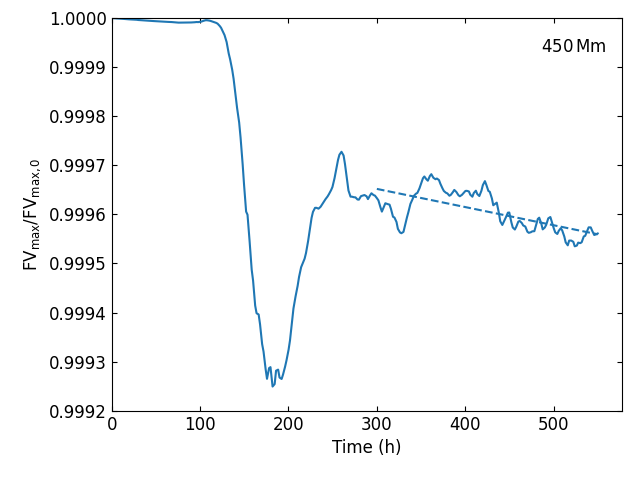

In [39]:
close(58);figure(58)
matplotlib.rcParams.update({'font.size': 12})
#plot(out_dat[case]['times']/60.,out_dat[case]['FVmax']/out_dat[case]['FVmax'][0],'-k', label='FV spline fit', color='tab:blue')
tt = out_dat[case]['times']
x = tt/60
y = (out_dat[case]['coeffs'].T[0]+0.1)/out_dat[case]['FVmax'][0]
plot(x,y,label='Gaussian at 550 Mm', color='tab:blue',ls='-')
#plot(tt/60,-3e-8*tt+0.9954,ls='--')
ylabel(r'FV$_{\rm max}$/FV$_{\rm{max},0}$')
xlabel('Time (h)')
tight_layout()
ax = plt.gca()
ax.tick_params(axis='both',direction='in',which='both')
ax.yaxis.set_ticks_position('both')
ax.xaxis.set_ticks_position('both')
ylim(.9992,1)
xlim(0,None)
#
tmin = 300
xa,ya = x[x>tmin], y[x>tmin]
print('Kendall',stats.kendalltau(xa,ya))
print('Pearson',stats.pearsonr(xa,ya))
xa = sm.add_constant(xa)
model = sm.OLS(ya,xa)
results = model.fit()
print(results.summary())
b,m = results.params
db,dm = results.bse
#
xx = linspace(300,550)
nsig = 1
nominal = b+m*xx
sig = np.sqrt(0*(nsig*db)**2 + ((m+nsig*dm)*xx)**2)
plt.plot(xx,nominal,'--')
text(0.97,0.95,r'450$\,$Mm', transform=ax.transAxes,ha='right',va='top')
savefig('FVmax450.pdf', bbox_inches='tight')
#
print(m/3600,dm/3600)
print(log10(-m/3600*8.3e8**2),log10(-(m+dm)/3600*8.3e8**2),log10(-(m-dm)/3600*8.3e8**2))

In [62]:
st, data, ss2 = summary_table(results, alpha=0.05)

fittedvalues = data[:, 2]
predict_mean_se  = data[:, 3]
predict_mean_ci_low, predict_mean_ci_upp = data[:, 4:6].T
predict_ci_low, predict_ci_upp = data[:, 6:8].T

$D = - \frac{\sigma_0^2}{{\rm FV}_0} \frac{d {\rm FV}_{\rm max}}{dt}$